<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Деление-датасета" data-toc-modified-id="Деление-датасета-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Деление датасета</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Линейная-регрессия-(LinearRegression)" data-toc-modified-id="Линейная-регрессия-(LinearRegression)-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Линейная регрессия (LinearRegression)</a></span></li><li><span><a href="#Дерево-решений-(DecisionTree)" data-toc-modified-id="Дерево-решений-(DecisionTree)-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Дерево решений (DecisionTree)</a></span></li><li><span><a href="#Случайный-лес-(RandomForest)" data-toc-modified-id="Случайный-лес-(RandomForest)-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Случайный лес (RandomForest)</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес-(RandomForest)" data-toc-modified-id="Случайный-лес-(RandomForest)-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Случайный лес (RandomForest)</a></span></li><li><span><a href="#Сводная-таблица-результатов" data-toc-modified-id="Сводная-таблица-результатов-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Сводная таблица результатов</a></span></li><li><span><a href="#Dummy" data-toc-modified-id="Dummy-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Dummy</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование количества заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нам предстоит построить модель для такого предсказания (значение метрики *RMSE* на тестовой выборке должно быть не больше 48).

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`.  
Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Произведем импорт всех необходимых бибилиотек:

In [267]:
# библиотеки работы с данными
import pandas as pd
import numpy as np
import lightgbm as lgb
import sklearn
import datetime as dt

# откючаем предупреждения
import warnings
warnings.filterwarnings('ignore')

# установка настроек для отображения всех колонок при печати
pd.set_option('display.max_columns', None)

# разделение на выборки
from sklearn.model_selection import train_test_split 

# графики
import matplotlib.pyplot as plt 

# модели
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

# стандартизация признаков
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

# метрики
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from math import sqrt

Прочитаем датафрейм, сразу определив столбец datetime как тип datetime:

In [268]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])

df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Можно проследить, что количество заказов подсчитывалось за каждые прошедшие 10 минут

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [270]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

В таблице 2 столбца:  
datetime - показывает даты и время (тип datetime64 мы установили при импорте датасета, изначально он был object)
num_orders - отображает количество заказов такси (целочисленный тип)

26496 строк и ни одного пропущенного значения

In [271]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [272]:
df.num_orders[df.num_orders == 0].count()

537

Видим, что присутствует 537 нулевых значений в столбце с заказами. Нули здесь не являются ошибкой, т.к. могут означать, что заказов такси не было в соответствующий нулю промежуток времени  

Больше половины значений имеют значение выше 12ти заказов в 10 мин.  
Максимальное количество заказов в 10 мин равно 119

Проверим наличие дубликатов:

In [273]:
df.duplicated().sum()

0

Дубликатов не найдено

После того как мы провели проверку, перезапишем датасет заново с установкой дат в качестве индексов:

In [274]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим отсортированы ли индексы:

In [275]:
df.index.is_monotonic

True

Выполним ресемплирование данных по одному часу:

In [276]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод**

В рамках данной главы мы произвели выгрузку библиотек, загрузили и просмотрели данные таблицы, содержащей историческую информацию о заказах такси в аэропорт. После первичного анализа загруженных данных на адекватность (отсутствие дубликатов и пропущенных значений), мы произвели повторную загрузку датасета с автоматической установкой даты индексом и ресеплирование по одному часу, согласно заданию.

## Анализ

Посмотрим на информацию о заказах по часам:

In [277]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Видим, что в среднем за час поступало примерно 85 заказов такси  
Стандартное отклонение равно 45 заказам

Построим гистограмму распределения количества заказов по часам:

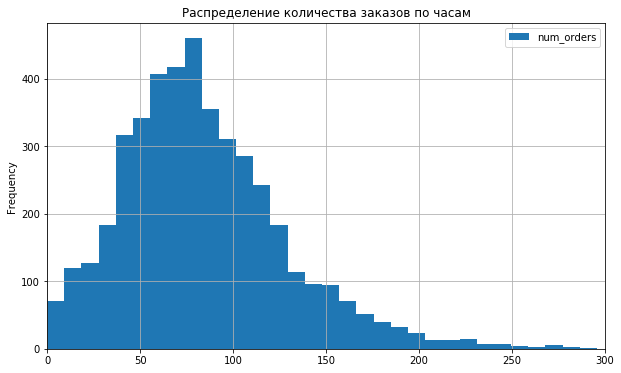

In [278]:
df.plot(kind='hist', bins = 50, grid = True, figsize = (10,6), xlim = (0,300), 
        title='Распределение количества заказов по часам')

plt.show()

По гистограмме видим, что в основном за 1 час происходит от 0 до 200 заказов. Очень редко заказов бывает более 200.  
По таблице describe мы видим, что максимум за час бывало 462, но такие случаи очень редки:

In [279]:
df[df > 200].count()

num_orders    81
dtype: int64

При помощи функции seasonal_decompose() разложим наш временной ряд на три составляющие: 
* тренд (decomposed.trend)
* сезонность (decomposed.seasonal)
* остаток (decomposed.resid)

И построим графики по каждой из них:

(None, <matplotlib.legend.Legend at 0x7f414c354e10>)

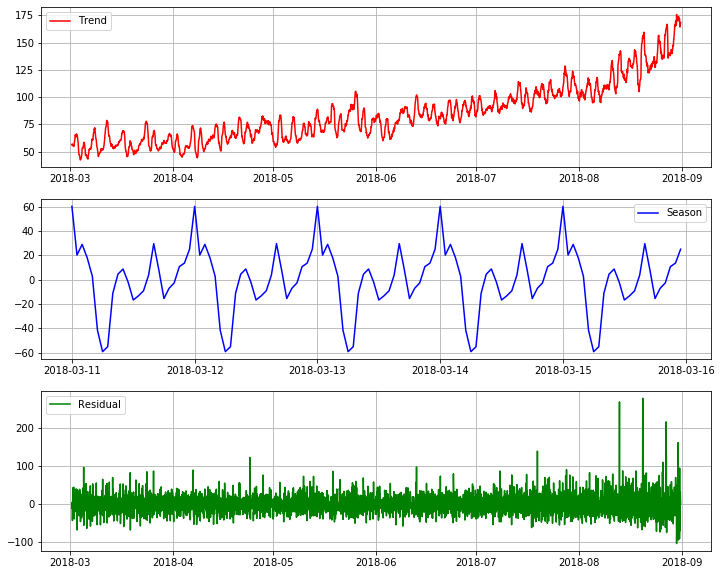

In [280]:
decomposed = seasonal_decompose(df)

fig , ax = plt.subplots(1, 3, figsize=(12, 10))

plt.subplot(3,1,1)
plt.plot(decomposed.trend, label = 'Trend', color = 'r')
plt.legend(), plt.grid()


plt.subplot(3,1,2)
plt.plot(decomposed.seasonal['2018-03-11':'2018-03-15'], label = 'Season', color = 'b')
plt.grid(), plt.legend()


plt.subplot(3,1,3)
plt.plot(decomposed.resid , label = 'Residual', color = 'g')
plt.grid(), plt.legend()

По графикам результатов декомпозиции можно отметить следующие важные моменты:
* тренд показывает нам, что количество заказов постепенно увеличивается
* сезоность указывает на высокий спрос на такси в ночное время (можно отметить, что это логично, т.к. общественный транспорт не работает ночью)
* остатки не поддаются анализу, т.к. являются просто шумом

## Обучение

### Создание признаков

Для обучения модели, нам очень мало будет одного столбца с индексами.  
Поэтому напишем функцию, чтобы вытащить из индекса (дата-время) информацию: месяц, год, день и день недели.  
Чтобы скользящее среднее в моменте t не учитывало текущее значение ряда x(t), вычислим его вызвав предварительно метод .shift. Так вычисление скользящего среднего не будет включать в себя текущее значение ряда.  
Запишем всё в новые столбцы.

In [281]:
def make_features(data, max_lag, rolling_sum_size):
    
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_sum_size).sum()

Применим функцию на датасете:

In [282]:
df.shape

(4416, 1)

In [283]:
make_features(df, 24, 8)
df.shape

(4416, 30)

In [284]:
df.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видим что в первых строках из-за добавления скользящего среднего появилось много пропусков,  
избавимся от них:

In [285]:
df = df.dropna()
df.isna().sum().sum()

0

In [286]:
df.head().T

datetime,2018-03-02 00:00:00,2018-03-02 01:00:00,2018-03-02 02:00:00,2018-03-02 03:00:00,2018-03-02 04:00:00
num_orders,90.0,120.0,75.0,64.0,20.0
year,2018.0,2018.0,2018.0,2018.0,2018.0
month,3.0,3.0,3.0,3.0,3.0
day,2.0,2.0,2.0,2.0,2.0
dayofweek,4.0,4.0,4.0,4.0,4.0
lag_1,58.0,90.0,120.0,75.0,64.0
lag_2,113.0,58.0,90.0,120.0,75.0
lag_3,66.0,113.0,58.0,90.0,120.0
lag_4,61.0,66.0,113.0,58.0,90.0
lag_5,45.0,61.0,66.0,113.0,58.0


Определим категориальные признаки (столбцы с месяцем и днем недели) как тип category

In [287]:
df[['month', 'dayofweek']] = df[['month', 'dayofweek']].astype('category')

df.dtypes

num_orders         int64
year               int64
month           category
day                int64
dayofweek       category
lag_1            float64
lag_2            float64
lag_3            float64
lag_4            float64
lag_5            float64
lag_6            float64
lag_7            float64
lag_8            float64
lag_9            float64
lag_10           float64
lag_11           float64
lag_12           float64
lag_13           float64
lag_14           float64
lag_15           float64
lag_16           float64
lag_17           float64
lag_18           float64
lag_19           float64
lag_20           float64
lag_21           float64
lag_22           float64
lag_23           float64
lag_24           float64
rolling_mean     float64
dtype: object

In [288]:
cat_cols = df.select_dtypes(include='category').columns.to_list()
cat_cols

['month', 'dayofweek']

### Деление датасета

Разделим датасет на таргет и фичи

In [289]:
features = df.drop(['num_orders'], axis=1)
target = df['num_orders']

print('Размер исходного датафрейма:', df.shape,
      '\nРазмер features:', features.shape,
      '\nРазмер target:', target.shape)

Размер исходного датафрейма: (4392, 30) 
Размер features: (4392, 29) 
Размер target: (4392,)


Определим тренировочную, валидационную и тестовую выборки:

In [290]:
features_1, features_test, target_1, target_test = train_test_split(
features, target, test_size=0.1, shuffle=False, random_state=42)

features_train, features_valid, target_train, target_valid = train_test_split(
features_1, target_1, test_size=0.2, shuffle=False, random_state=42)

print('Размер train:', features_train.shape, target_train.shape,
      '\nРазмер valid:', features_valid.shape, target_valid.shape,
      '\nРазмер test:', features_test.shape, target_test.shape)

Размер train: (3161, 29) (3161,) 
Размер valid: (791, 29) (791,) 
Размер test: (440, 29) (440,)


In [291]:
len(df) == len(features_train) + len(features_valid) + len(features_test)

True

Также позже мы используем для повторной тренировки модели датасет (трейн + валид):

In [292]:
len(df) == len(features_1) + len(features_test)

True

### Catboost

Catboost разработан для категориальной подготовки данных, но также применим к регрессионным задачам.  
Попробуем применить его в нашем проекте

Установим у модели Catboost следующие гиперпараметры:  
* learning rate = 0.4 - скорость обучения
* early_stopping_rounds = 20 - детектор переобучения - останавливает обучение после указанного количества итераций (установим как 20) с момента итерации, где было достигнуто оптимальное значение метрики
* depth = 6 - глубина дерева, оптимальными значениями, которые стоит попробовать - это 6 и 10 (при 10 метрика в данном случае оказалась хуже)
* verbose = 10 - вывод результатов каждые 10 шагов

In [293]:
train_pool = Pool(features_train, 
                  target_train, 
                  cat_features=cat_cols)
valid_pool = Pool(features_valid, 
                 cat_features=cat_cols) 
test_pool = Pool(features_test, 
                 cat_features=cat_cols) 
eval_pool = Pool(features_valid, target_valid,
                 cat_features=cat_cols)

In [294]:
%%time

model_cb = CatBoostRegressor(learning_rate=0.1,
                             iterations=1000,
                             #depth=6,  
                             random_seed=42)

# model_cb.fit(train_pool, verbose=10)
model_cb.fit(train_pool,
             eval_set=eval_pool,
             verbose=10,
             early_stopping_rounds = 30)

print('Время обучения:')

0:	learn: 32.7557079	test: 53.1327956	best: 53.1327956 (0)	total: 5.97ms	remaining: 5.97s
10:	learn: 24.7777505	test: 43.1119826	best: 43.1119826 (10)	total: 492ms	remaining: 44.2s
20:	learn: 22.2041226	test: 38.4805569	best: 38.4805569 (20)	total: 1.07s	remaining: 50s
30:	learn: 21.1767696	test: 36.9027453	best: 36.9027453 (30)	total: 1.66s	remaining: 51.9s
40:	learn: 20.3948839	test: 36.0896040	best: 36.0896040 (40)	total: 2.25s	remaining: 52.6s
50:	learn: 19.8758458	test: 35.4823410	best: 35.4823410 (50)	total: 2.84s	remaining: 52.8s
60:	learn: 19.4562719	test: 34.9807837	best: 34.9564174 (59)	total: 3.42s	remaining: 52.7s
70:	learn: 19.0847359	test: 34.8380386	best: 34.8380386 (70)	total: 3.92s	remaining: 51.3s
80:	learn: 18.7208390	test: 34.6434117	best: 34.6320300 (79)	total: 4.43s	remaining: 50.2s
90:	learn: 18.3596920	test: 34.4701259	best: 34.4701259 (90)	total: 4.94s	remaining: 49.4s
100:	learn: 17.9466952	test: 34.2072697	best: 34.2070054 (97)	total: 5.51s	remaining: 49.1s
1

Посмотрим на лучшие показатели метрики RMSE при обучении и валидации:

In [295]:
model_cb.best_score_

{'learn': {'RMSE': 15.07085751514026},
 'validation': {'RMSE': 33.534934651369504}}

In [296]:
%%time

preds_cb = model_cb.predict(valid_pool)

cb_valid_rmse = (mean_squared_error(target_valid, preds_cb) ** 0.5).round(2)

print('rMSE на valid:', cb_valid_rmse,
     '\nВремя предсказания:')

rMSE на valid: 33.53 
Время предсказания:
CPU times: user 0 ns, sys: 7.01 ms, total: 7.01 ms
Wall time: 2.57 ms


Сохраним эти значения и время обучения лучшей модели в переменные, чтобы не потерять:

In [297]:
cb_train_rmse = round(model_cb.best_score_['learn']['RMSE'], 2)
cb_train_time = 3.91

print('Catboost RMSE на train', cb_train_rmse,
     '\nCatboost RMSE на valid', cb_valid_rmse)

Catboost RMSE на train 15.07 
Catboost RMSE на valid 33.53


### LightGBM

LightGBM — это фреймворк, который предоставляет реализацию деревьев принятия решений с градиентным бустингом.    

Определим в 2 переменных обучающий и тестовый наборы для передачи в качестве параметров в модель LightGBM:

In [298]:
train_data = lgb.Dataset(features_train, target_train, categorical_feature=cat_cols)
valid_data = lgb.Dataset(features_valid, target_valid, categorical_feature=cat_cols)

Гиперпараметры:

* gbdt - traditional Gradient Boosting Decision Tree (по-дефолту = gbrt) - нас устраивает
* objective - по-дефолту = regression - подходит
* кол-во итераций num_boost_round установим в 300
* verbose_eval = 10 - будем выводить также как в кэтбусте каждый 10й результат
* early_stopping_rounds = 50 - детектор переобучения
* также передадим категориальные переменные cat_cols

Обучим модель LightGBM и посмотрим на время выполнения ячейки:

In [299]:
%%time

params = {"metric":'rmse',
          "learning_rate":0.2,
          "seed":42}

model_lgb = lgb.train(params, 
                       train_data, 
                       valid_sets=(train_data, valid_data),
                       num_boost_round=300,
                       categorical_feature=cat_cols,
                       verbose_eval=10,
                       early_stopping_rounds = 100
                      )

print('\n\nВремя выполнения кода:')

Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 18.241	valid_1's rmse: 36.3354
[20]	training's rmse: 14.9578	valid_1's rmse: 34.4394
[30]	training's rmse: 13.1154	valid_1's rmse: 33.8671
[40]	training's rmse: 11.5831	valid_1's rmse: 34.1063
[50]	training's rmse: 10.3669	valid_1's rmse: 34.0481
[60]	training's rmse: 9.16526	valid_1's rmse: 34.2023
[70]	training's rmse: 8.24918	valid_1's rmse: 34.1148
[80]	training's rmse: 7.5063	valid_1's rmse: 34.1222
[90]	training's rmse: 6.78431	valid_1's rmse: 34.0199
[100]	training's rmse: 6.11565	valid_1's rmse: 33.9694
[110]	training's rmse: 5.5768	valid_1's rmse: 33.9985
[120]	training's rmse: 5.06193	valid_1's rmse: 34.0616
Early stopping, best iteration is:
[28]	training's rmse: 13.4414	valid_1's rmse: 33.7463


Время выполнения кода:
CPU times: user 4.2 s, sys: 58.9 ms, total: 4.25 s
Wall time: 4.33 s


Сохраним результаты в переменные:

In [300]:
lgbm_train_rmse = round(mean_squared_error(target_train, model_lgb.predict(features_train)) ** 0.5, 2)
lgbm_valid_rmse = round(mean_squared_error(target_valid, model_lgb.predict(features_valid)) ** 0.5, 2)
lgbm_train_time = 1.180

print('LightGBM RMSE на train', lgbm_train_rmse,
     '\nLightGBM RMSE на valid', lgbm_valid_rmse)

LightGBM RMSE на train 13.44 
LightGBM RMSE на valid 34.17


Этот результат чуть хуже, чем у модели Catboost:

In [301]:
print('Catboost RMSE на train', cb_train_rmse,
     '\nCatboost RMSE на valid', cb_valid_rmse)

Catboost RMSE на train 15.07 
Catboost RMSE на valid 33.53


**Далее рассмотрим более простые модели: Линейная регрессия, Дерево решений, Случайный лес**

### Линейная регрессия (LinearRegression)

Применим кодирование категориальных признаков и масштабирование признаков и попробуем обучить модель LinearRegression и посчитать метрику RMSE

Для кодирования категориальных признаков с небольшим количеством значений в столбце используем метод прямого кодирования(OHE):

In [302]:
features_train_lr = pd.get_dummies(features_train, columns=['month', 'dayofweek'], drop_first=True)
features_test_lr = pd.get_dummies(features_test, columns=['month', 'dayofweek'], drop_first=True)
features_valid_lr = pd.get_dummies(features_valid, columns=['month', 'dayofweek'], drop_first=True)

features_train_lr.head()

,year,day,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,month_4,month_5,month_6,month_7,month_8,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,2018,2,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,503.0,0,0,0,0,0,0,0,0,1,0,0
2018-03-02 01:00:00,2018,2,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,550.0,0,0,0,0,0,0,0,0,1,0,0
2018-03-02 02:00:00,2018,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,626.0,0,0,0,0,0,0,0,0,1,0,0
2018-03-02 03:00:00,2018,2,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,628.0,0,0,0,0,0,0,0,0,1,0,0
2018-03-02 04:00:00,2018,2,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,647.0,0,0,0,0,0,0,0,0,1,0,0


Мы видим, что данные имеют большой разброс, следовательно перед обучением модели линейной регрессии, нам необходимо отмасштабировать данные методом стандартизации. Для того, чтобы избежать переобучения, обучим стандартизатор на тренировочном датасете, а стандартизировать будем всё:

In [303]:
scaler = StandardScaler()

scaler.fit(features_train_lr) 
features_train_lr = pd.DataFrame(scaler.transform(features_train_lr), columns=features_train_lr.columns)
features_valid_lr = pd.DataFrame(scaler.transform(features_valid_lr), columns=features_valid_lr.columns)
features_test_lr = pd.DataFrame(scaler.transform(features_test_lr), columns=features_test_lr.columns)

features_train_lr.head()

,year,day,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,month_4,month_5,month_6,month_7,month_8,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,0.0,-1.474782,-0.391074,1.214243,-0.157332,-0.302813,-0.769891,0.047968,-0.798437,-0.827108,-0.155286,-0.681294,-1.147990,-1.205694,0.722528,-0.212159,-0.065297,-1.088624,-1.644509,-1.730888,-1.905305,-0.821857,-0.148612,-0.002084,0.407636,1.548831,-0.416965,-0.543103,-0.554815,-0.543103,-0.297487,0.0,-0.410581,-0.406891,-0.397869,2.435573,-0.410581,-0.410581
1,0.0,-1.474782,0.543107,-0.391158,1.214724,-0.156793,-0.302661,-0.769746,0.048496,-0.797902,-0.827015,-0.155499,-0.680708,-1.147297,-1.206155,0.723217,-0.211578,-0.064823,-1.088203,-1.643086,-1.729698,-1.904933,-0.821878,-0.148452,-0.002186,0.407408,-0.128500,-0.543103,-0.554815,-0.543103,-0.297487,0.0,-0.410581,-0.406891,-0.397869,2.435573,-0.410581,-0.410581
2,0.0,-1.474782,1.418901,0.542894,-0.390874,1.215796,-0.156652,-0.302481,-0.769233,0.049061,-0.797809,-0.827348,-0.155015,-0.680120,-1.147710,-1.205997,0.724623,-0.211081,-0.063431,-1.087005,-1.641895,-1.729299,-1.904958,-0.821747,-0.148550,-0.002333,0.337954,-0.543103,-0.554815,-0.543103,-0.297487,0.0,-0.410581,-0.406891,-0.397869,2.435573,-0.410581,-0.410581
3,0.0,-1.474782,0.105210,1.418567,0.543293,-0.390425,1.215837,-0.156460,-0.301959,-0.768697,0.049153,-0.798137,-0.826734,-0.154546,-0.680150,-1.147536,-1.206292,0.724966,-0.209827,-0.062646,-1.085807,-1.641482,-1.729323,-1.904874,-0.821828,-0.148670,0.350229,-0.543103,-0.554815,-0.543103,-0.297487,0.0,-0.410581,-0.406891,-0.397869,2.435573,-0.410581,-0.410581
4,0.0,-1.474782,-0.215915,0.105057,1.419073,0.544104,-0.390267,1.216131,-0.155936,-0.301407,-0.768604,0.048977,-0.797528,-0.826113,-0.154146,-0.679848,-1.147779,-1.205630,0.727108,-0.208983,-0.061434,-1.085308,-1.641506,-1.729232,-1.904928,-0.821816,0.466843,-0.543103,-0.554815,-0.543103,-0.297487,0.0,-0.410581,-0.406891,-0.397869,2.435573,-0.410581,-0.410581


In [304]:
%%time

model_lr =  LinearRegression()
model_lr.fit(features_train_lr, target_train)

pred_lr = model_lr.predict(features_valid_lr)

lr_valid_rmse = (mean_squared_error(target_valid, pred_lr) ** 0.5).round(2)

print('LinearRegression RMSE на valid (после масштабирования):', lr_valid_rmse,
     '\n\nВремя выполнения ячейки:')

LinearRegression RMSE на valid (после масштабирования): 144.65 

Время выполнения ячейки:
CPU times: user 82.8 ms, sys: 145 ms, total: 228 ms
Wall time: 233 ms


Результат получился хуже, чем у бустинговых моделей

### Дерево решений (DecisionTree)

С помощью метода основанного на кросс-валидации (RandomizedSearchCV) подберем лучшие параметры дерева решений и сохраним их

In [305]:
%%time




model_dt = DecisionTreeRegressor(random_state=42)

dt_params = {
    'max_depth':[x for x in range(1, 50, 1)], 
    'min_samples_leaf':[x for x in range(2, 20, 1)],
    'min_samples_split':[x for x in range(2, 20, 1)],
}

tree_grid = RandomizedSearchCV(model_dt, dt_params, 
                               scoring='neg_mean_squared_error', 
                               cv=TimeSeriesSplit(n_splits=10),
                               n_iter=20,
                               random_state=45)

tree_grid.fit(features_train_lr, target_train)

model_dt = DecisionTreeRegressor(random_state=42, **tree_grid.best_params_)

print('Лучшие параметры DecisionTree:\n', tree_grid.best_params_,
     '\n\nВремя подбора параметров:')

Лучшие параметры DecisionTree:
 {'min_samples_split': 10, 'min_samples_leaf': 17, 'max_depth': 25} 

Время подбора параметров:
CPU times: user 6.19 s, sys: 820 µs, total: 6.19 s
Wall time: 6.24 s


Обучим модель с уже подобранными параметрами:

In [306]:
%%time
model_dt.fit(features_train_lr, target_train)

CPU times: user 52.2 ms, sys: 0 ns, total: 52.2 ms
Wall time: 62.3 ms


DecisionTreeRegressor(criterion='mse', max_depth=25, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=17,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

Получим предсказания на валидационной выборке:

In [307]:
%%time

preds_dt = model_dt.predict(features_valid_lr)

dt_valid_rmse = (mean_squared_error(target_valid, preds_dt) ** 0.5).round(2)

print('DecisionTreeRegressor RMSE на valid:', dt_valid_rmse,
     '\n\nВремя предсказания:')

DecisionTreeRegressor RMSE на valid: 39.84 

Время предсказания:
CPU times: user 4.47 ms, sys: 0 ns, total: 4.47 ms
Wall time: 3.31 ms


Сохраним время обучения и предсказания в секундах:

In [308]:
dt_train_time = 0.009
dt_pred_time = 0.003

RMSE на valid по результатам предсказаний дерева решений получился 44.6, такой результат оказался хуже всех остальных моделей

### Случайный лес (RandomForest)

Подберем лучшие параметры случайного леса и сохраним их:

In [309]:
%%time

model_f = RandomForestRegressor(random_state=42)

forest_params = {
    'n_estimators': range(1, 61, 10),
    'max_depth': range(1, 21, 1), 
    'min_samples_leaf': range(2, 11, 1),
    'min_samples_split': range(2, 11, 1),
}

forest_grid = RandomizedSearchCV(model_f, forest_params, 
                                 scoring='neg_mean_squared_error',
                                 cv=TimeSeriesSplit(n_splits=10),
                                 n_iter=10, random_state=42)

forest_grid.fit(features_train_lr, target_train)

model_f = RandomForestRegressor(random_state=42, **forest_grid.best_params_)

print('Лучшие параметры RandomForest:', forest_grid.best_params_,
     '\n\nВремя подбора параметров:')

Лучшие параметры RandomForest: {'n_estimators': 41, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_depth': 12} 

Время подбора параметров:
CPU times: user 41.2 s, sys: 0 ns, total: 41.2 s
Wall time: 41.2 s


Обучим модель с уже подобранными параметрами:

In [310]:
%%time
model_f.fit(features_train_lr, target_train)

CPU times: user 1.5 s, sys: 0 ns, total: 1.5 s
Wall time: 1.51 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=41,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [311]:
%%time

preds_f = model_f.predict(features_valid_lr)

f_valid_rmse = (mean_squared_error(target_valid, preds_f) ** 0.5).round(2)

print('RandomForest RMSE на valid:', f_valid_rmse,
     '\n\nВремя предсказания:')

RandomForest RMSE на valid: 35.71 

Время предсказания:
CPU times: user 13.9 ms, sys: 0 ns, total: 13.9 ms
Wall time: 12.6 ms


Результат RMSE предсказаний на валидационной выборке у модели Случайного леса получился лучше чем у Дерева решений и Линейной регрессии

In [312]:
f_train_time = 0.74
f_pred_time = 0.012

## Тестирование

Теперь обучим модели заново на train+valid датасете (features_1) и посмотрим результаты на тестовой выборке:

### CatBoost

In [313]:
%%time

train_pool_1 = Pool(features_1, 
                  target_1, 
                  cat_features=cat_cols)

model_cb = CatBoostRegressor(learning_rate=0.4,
                             iterations=500, 
                             depth=6,  
                             random_seed=42)

model_cb.fit(train_pool_1, verbose=20)

print('\n\nВремя обучения:')

0:	learn: 32.7371090	total: 16.5ms	remaining: 8.23s
20:	learn: 21.7873557	total: 1s	remaining: 22.9s
40:	learn: 18.9794093	total: 2.19s	remaining: 24.5s
60:	learn: 16.9404041	total: 3.44s	remaining: 24.8s
80:	learn: 15.1196652	total: 4.63s	remaining: 23.9s
100:	learn: 13.8799331	total: 5.8s	remaining: 22.9s
120:	learn: 12.7640810	total: 6.98s	remaining: 21.9s
140:	learn: 11.8026310	total: 8.18s	remaining: 20.8s
160:	learn: 10.9786904	total: 9.27s	remaining: 19.5s
180:	learn: 10.1681005	total: 10.5s	remaining: 18.4s
200:	learn: 9.4495206	total: 11.6s	remaining: 17.3s
220:	learn: 8.8862046	total: 12.8s	remaining: 16.2s
240:	learn: 8.2327971	total: 14s	remaining: 15.1s
260:	learn: 7.6979083	total: 15.1s	remaining: 13.9s
280:	learn: 7.1238595	total: 16.1s	remaining: 12.5s
300:	learn: 6.6490144	total: 17s	remaining: 11.2s
320:	learn: 6.2168588	total: 18.2s	remaining: 10.1s
340:	learn: 5.9020840	total: 19.3s	remaining: 8.98s
360:	learn: 5.5360181	total: 20.5s	remaining: 7.87s
380:	learn: 5.2

In [314]:
%%time

cb_preds = model_cb.predict(features_test)

cb_test_rmse = (mean_squared_error(target_test, cb_preds) ** 0.5).round(2)

print('CatBoost RMSE на test:', cb_test_rmse,
     '\n\nВремя предсказания:')

CatBoost RMSE на test: 43.59 

Время предсказания:
CPU times: user 9.84 ms, sys: 482 µs, total: 10.3 ms
Wall time: 4.25 ms


In [315]:
cb_pred_time = 0.015

In [316]:
model_cb.best_score_

{'learn': {'RMSE': 3.6752922954539113}}

RMSE на тестовой выборке вышел 63.94.  
Результаты метрики оказались значительно хуже, чем на обучающих и валидационных данных:

In [317]:
print('Catboost RMSE на train', cb_train_rmse,
     '\nCatboost RMSE на valid', cb_valid_rmse,
     '\nCatBoost RMSE на test', cb_test_rmse)

Catboost RMSE на train 15.07 
Catboost RMSE на valid 33.53 
CatBoost RMSE на test 43.59


### LightGBM

In [318]:
%%time

train_data_1 = lgb.Dataset(features_1, target_1, categorical_feature=cat_cols)
test_data = lgb.Dataset(features_test, target_test, categorical_feature=cat_cols)

params = {"metric":'rmse',
          "seed":42}

model_lgb = lgb.train(params, 
                       train_data_1, 
                       valid_sets=(train_data_1, test_data),
                       num_boost_round=300,
                       categorical_feature=cat_cols,
                       verbose_eval=20,
                       #early_stopping_rounds = 50
                      )

print('\n\nВремя выполнения кода:')

[20]	training's rmse: 20.7808	valid_1's rmse: 46.3625
[40]	training's rmse: 17.2738	valid_1's rmse: 42.2424
[60]	training's rmse: 15.2659	valid_1's rmse: 41.3371
[80]	training's rmse: 13.7139	valid_1's rmse: 40.9708
[100]	training's rmse: 12.4576	valid_1's rmse: 40.713
[120]	training's rmse: 11.302	valid_1's rmse: 40.4843
[140]	training's rmse: 10.3967	valid_1's rmse: 40.5451
[160]	training's rmse: 9.61982	valid_1's rmse: 40.6379
[180]	training's rmse: 8.84617	valid_1's rmse: 40.6095
[200]	training's rmse: 8.15667	valid_1's rmse: 40.5802
[220]	training's rmse: 7.46703	valid_1's rmse: 40.6367
[240]	training's rmse: 6.89815	valid_1's rmse: 40.689
[260]	training's rmse: 6.41615	valid_1's rmse: 40.6849
[280]	training's rmse: 5.94408	valid_1's rmse: 40.7112
[300]	training's rmse: 5.50242	valid_1's rmse: 40.6754


Время выполнения кода:
CPU times: user 8.43 s, sys: 84 ms, total: 8.51 s
Wall time: 8.62 s


In [319]:
%%time

lgb_preds = model_lgb.predict(features_test, num_iteration=model_lgb.best_iteration)

lgbm_test_rmse = (mean_squared_error(target_test, lgb_preds) ** 0.5).round(2)

print('LightGBM RMSE на test:', lgbm_test_rmse,
     '\n\nВремя предсказания:')

LightGBM RMSE на test: 40.68 

Время предсказания:
CPU times: user 85.1 ms, sys: 6.11 ms, total: 91.2 ms
Wall time: 92.4 ms


In [320]:
lgbm_pred_time = 0.009

Результат метрики RMSE на тесте, также как у Catboost, оказался хуже почти в 2 раза, чем на валидационном датасете:

In [321]:
print('LightGBM RMSE на train', lgbm_train_rmse,
     '\nLightGBM RMSE на valid', lgbm_valid_rmse,
     '\nLightGBM RMSE на test', lgbm_test_rmse)

LightGBM RMSE на train 13.44 
LightGBM RMSE на valid 34.17 
LightGBM RMSE на test 40.68


Результат чуть лучше чем у кэтбуста, но цель по-прежнему не достигнута (нужно меньше 48)

### Линейная регрессия

In [322]:
features_train_lr_1 = pd.get_dummies(features_1, columns=['month', 'dayofweek'], drop_first=True)

scaler.fit(features_train_lr_1) 
features_train_lr_1 = pd.DataFrame(scaler.transform(features_train_lr_1), columns=features_train_lr_1.columns)

features_train_lr_1.head()

,year,day,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,month_4,month_5,month_6,month_7,month_8,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,0.0,-1.494599,-0.528019,0.893921,-0.320922,-0.450002,-0.863303,-0.138632,-0.888637,-0.914121,-0.319097,-0.784822,-1.198373,-1.249583,0.459317,-0.371034,-0.239546,-1.158687,-1.658000,-1.735774,-1.892353,-0.919243,-0.314539,-0.183060,0.185170,1.211019,-0.631475,-0.471988,-0.481581,-0.471988,-0.481581,-0.288675,-0.40293,-0.40293,-0.40293,2.420973,-0.413057,-0.413057
1,0.0,-1.494599,0.299361,-0.528062,0.894380,-0.320716,-0.449476,-0.863199,-0.138050,-0.888241,-0.914406,-0.318958,-0.784347,-1.197821,-1.249931,0.466881,-0.370903,-0.238808,-1.158312,-1.656894,-1.734622,-1.891852,-0.919127,-0.314491,-0.182881,0.185419,-0.392226,-0.471988,-0.481581,-0.471988,-0.481581,-0.288675,-0.40293,-0.40293,-0.40293,2.420973,-0.413057,-0.413057
2,0.0,-1.494599,1.075030,0.299273,-0.527782,0.894574,-0.320155,-0.449161,-0.862755,-0.137723,-0.888523,-0.914228,-0.318567,-0.783730,-1.198136,-1.261318,0.469779,-0.370219,-0.237833,-1.157327,-1.655756,-1.734131,-1.891724,-0.919076,-0.314328,-0.182744,-0.005354,-0.471988,-0.481581,-0.471988,-0.481581,-0.288675,-0.40293,-0.40293,-0.40293,2.420973,-0.413057,-0.413057
3,0.0,-1.494599,-0.088473,1.074900,0.299658,-0.527574,0.895464,-0.319774,-0.448638,-0.862361,-0.137916,-0.888347,-0.913730,-0.317877,-0.783772,-1.208949,-1.264128,0.470813,-0.369330,-0.237070,-1.156273,-1.655271,-1.734006,-1.891670,-0.918983,-0.314232,0.004826,-0.471988,-0.481581,-0.471988,-0.481581,-0.288675,-0.40293,-0.40293,-0.40293,2.420973,-0.413057,-0.413057
4,0.0,-1.494599,-0.372885,-0.088540,1.075383,0.299858,-0.527069,0.896462,-0.319226,-0.448282,-0.862640,-0.137789,-0.887853,-0.913134,-0.317614,-0.789991,-1.211585,-1.263816,0.472251,-0.368535,-0.236172,-1.155824,-1.655146,-1.733952,-1.891689,-0.919072,0.101544,-0.471988,-0.481581,-0.471988,-0.481581,-0.288675,-0.40293,-0.40293,-0.40293,2.420973,-0.413057,-0.413057


In [323]:
%%time

model_lr_3 =  LinearRegression()
model_lr_3.fit(features_train_lr_1, target_1)

pred_lr_test = model_lr_3.predict(features_test_lr)

lr_test_rmse = (mean_squared_error(target_test, pred_lr_test).round(5) ** 0.5).round(2)

print('LinearRegression RMSE на test:', lr_test_rmse,
     '\n\nВремя выполнения ячейки:')

LinearRegression RMSE на test: 4617223753486.72 

Время выполнения ячейки:
CPU times: user 94.6 ms, sys: 117 ms, total: 211 ms
Wall time: 223 ms


### Дерево решений

In [324]:
%%time

model_dt = DecisionTreeRegressor(random_state=42)

dt_params = {
    'max_depth':[x for x in range(1, 50, 1)], 
    'min_samples_leaf':[x for x in range(2, 20, 1)],
    'min_samples_split':[x for x in range(2, 20, 1)],
}

tree_grid = RandomizedSearchCV(model_dt, dt_params, 
                               scoring='neg_mean_squared_error', 
                               n_iter=20, random_state=45, cv=TimeSeriesSplit(n_splits=10))

tree_grid.fit(features_train_lr_1, target_1)

model_dt = DecisionTreeRegressor(random_state=42, **tree_grid.best_params_)

print('Лучшие параметры DecisionTree:\n', tree_grid.best_params_,
     '\n\nВремя подбора параметров:')

Лучшие параметры DecisionTree:
 {'min_samples_split': 7, 'min_samples_leaf': 19, 'max_depth': 22} 

Время подбора параметров:
CPU times: user 7.79 s, sys: 3.37 ms, total: 7.8 s
Wall time: 7.81 s


In [325]:
%%time
model_dt.fit(features_train_lr_1, target_1)

CPU times: user 63.8 ms, sys: 0 ns, total: 63.8 ms
Wall time: 62.2 ms


DecisionTreeRegressor(criterion='mse', max_depth=22, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=19,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [326]:
%%time

preds_test_dt = model_dt.predict(features_test_lr)

dt_test_rmse = (mean_squared_error(target_test, preds_test_dt) ** 0.5).round(2)

print('DecisionTreeRegressor RMSE на test:', dt_test_rmse,
     '\n\nВремя предсказания:')

DecisionTreeRegressor RMSE на test: 47.87 

Время предсказания:
CPU times: user 4.27 ms, sys: 6 µs, total: 4.27 ms
Wall time: 3.48 ms


### Случайный лес (RandomForest)

In [327]:
%%time

model_f = RandomForestRegressor(random_state=42)

forest_params = {
    'n_estimators': range(1, 61, 10),
    'max_depth': range(1, 21, 1), 
    'min_samples_leaf': range(2, 11, 1),
    'min_samples_split': range(2, 11, 1),
}

forest_grid = RandomizedSearchCV(model_f, forest_params, 
                                 scoring='neg_mean_squared_error', 
                                 n_iter=10, random_state=42, cv=TimeSeriesSplit(n_splits=10))

forest_grid.fit(features_train_lr_1, target_1)

model_f = RandomForestRegressor(random_state=42, **forest_grid.best_params_)

print('Лучшие параметры RandomForest:', forest_grid.best_params_,
     '\n\nВремя подбора параметров:')

Лучшие параметры RandomForest: {'n_estimators': 41, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10} 

Время подбора параметров:
CPU times: user 51.8 s, sys: 0 ns, total: 51.8 s
Wall time: 52.3 s


In [328]:
%%time
model_f.fit(features_train_lr_1, target_1)

CPU times: user 1.92 s, sys: 0 ns, total: 1.92 s
Wall time: 1.93 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=41,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [329]:
%%time

preds_test_f = model_f.predict(features_test_lr)

f_test_rmse = (mean_squared_error(target_test, preds_test_f) ** 0.5).round(2)

print('RandomForest RMSE на test:', f_test_rmse,
     '\n\nВремя предсказания:')

RandomForest RMSE на test: 44.12 

Время предсказания:
CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 9.61 ms


### Сводная таблица результатов

In [330]:
tabl = [
        [cb_valid_rmse, cb_test_rmse, cb_train_time, cb_pred_time],
        [lgbm_valid_rmse, lgbm_test_rmse, lgbm_train_time, lgbm_pred_time],
        [lr_valid_rmse, f_test_rmse, f_train_time, f_pred_time],
        [dt_valid_rmse, dt_test_rmse, dt_train_time, dt_pred_time],
        [f_valid_rmse, f_test_rmse, f_train_time, f_pred_time]
       ]
     
index = ['Catboost', 'LightGBM', 'LinearRegression', 'DecisionTree', 'RandomForest']
columns = ['Valid_RMSE', 'Test_RMSE', 'Train_Time[s]', 'Predict_Time[s]']

tabl = pd.DataFrame(tabl, index=index, columns=columns)
tabl

,Valid_RMSE,Test_RMSE,Train_Time[s],Predict_Time[s]
Catboost,33.53,43.59,3.910,0.015
LightGBM,34.17,40.68,1.180,0.009
LinearRegression,144.65,44.12,0.740,0.012
DecisionTree,39.84,47.87,0.009,0.003
RandomForest,35.71,44.12,0.740,0.012


In [331]:
tabl[tabl["Test_RMSE"] == tabl["Test_RMSE"].min()].index

Index(['LightGBM'], dtype='object')

In [332]:
tabl[tabl["Valid_RMSE"] == tabl["Valid_RMSE"].min()].index

Index(['Catboost'], dtype='object')

### Dummy
Проверим предсказания моделей на адекватность при помощи dummy модели:

In [333]:
dummy_model = DummyRegressor(strategy="median")
dummy_model.fit(features_train, target_train)
dummy_predict = dummy_model.predict(features_test)

rmse_dummy = (mean_squared_error(target_test, dummy_predict) ** 0.5).round(2)

print('RMSE Dummy:', rmse_dummy)

RMSE Dummy: 91.74


Все модели оказались лучше, чем простейший прогноз

###### Вывод

В рамках данного проекта было построено 5 моделей машинного обучения с целью спрогнозировать количество заказов такси на следующий час.  

Самое лучшее качество предсказаний получилось у бустинговой модели LightGBM (40.68 - на тестовых данных).
LinearRegression (44.12), RandomForest (44.12) и CatBoost (43.59) дают схожие результаты по качеству предсказаний  на тестовых данных.  

Дерево решений показало наихудший результат и в учет ее лучше не брать. 

таким образом для предсказаний рекомендуется выбрать модель LightGBM.